## Viajero de Comercio

Comportamiento del AG en problemas de optimacion

Inicializar librerias, variables, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42)


<ipython-input-1-d6810a2e3a0b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Ahora debemos considerar la cuestión de cómo podríamos representar TSP en código. Obviamente, necesitaremos algunas ciudades y algo de información sobre la distancia entre estas ciudades.

Una solución es considerar matrices de adyacencia

In [2]:
cities = [0, 1, 2, 3, 4]

adjacency_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)

# Pasamos a implementar el AG

Primero, definamos una clase para representar a la población. Decidí ir con una implementación basada en clases para adjuntar información sobre una generación específica de población a ese objeto de clase. 

In [3]:
class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat


Código que usaremos para generar aleatoriamente la primera generación de población.

In [4]:
def init_population(cities, adjacency_mat, n_population):
    return Population(
        np.asarray([np.random.permutation(cities) for _ in range(n_population)]), 
        adjacency_mat
    )


Veamos si todo va bien

In [5]:
pop = init_population(cities, adjacency_mat, 5)
pop.bag



array([[1, 4, 2, 0, 3],
       [3, 1, 2, 0, 4],
       [1, 0, 3, 4, 2],
       [0, 1, 2, 3, 4],
       [0, 2, 3, 1, 4]])

Ahora necesitamos alguna función que determine la aptitud de un cromosoma. En el contexto de TSP, la aptitud se define en términos muy simples: cuanto más corta es la distancia total,

In [6]:
def fitness(self, chromosome):
    return sum(
        [
            self.adjacency_mat[chromosome[i], chromosome[i + 1]]
            for i in range(len(chromosome) - 1)
        ]
    )

Population.fitness = fitness


A continuación, evaluamos la población.

In [7]:
def evaluate(self):
    try:
      distances = np.asarray([fitness(chromosome,self.adjacency_mat) for chromosome in self.bag])
    except:
      distances = np.asarray([self.fitness(chromosome) for chromosome in self.bag])
    self.score = np.min(distances)
    self.best = self.bag[distances.tolist().index(self.score)]
    self.parents.append(self.best)
    if False in (distances[0] == distances):
        distances = np.max(distances) - distances
    return distances / np.sum(distances)
    
Population.evaluate = evaluate


Cuando llamamos a pop.evaluate (), obtenemos un vector de probabilidad como se esperaba.

In [8]:
pop.evaluate()


array([0.19370949, 0.21905217, 0.        , 0.17431729, 0.41292105])

Cuando llamamos a pop.best, obtenemos el mejor elemento de la población

In [9]:
pop.best


array([0, 2, 3, 1, 4])

También podemos tener la puntuación del mejor cromosoma. 

In [10]:
pop.score


86.25

Ahora, seleccionaremos k número de padres para que sean la base de la próxima generación. Aquí, usamos un modelo de ruleta simple, donde comparamos el valor del vector de probabilidad y un número aleatorio muestreado de una distribución uniforme.

In [11]:
def select(self, k=4):
    fit = self.evaluate()
    while len(self.parents) < k:
        idx = np.random.randint(0, len(fit))
        if fit[idx] > np.random.rand():
            self.parents.append(self.bag[idx])
    self.parents = np.asarray(self.parents)

Population.select = select


Seleccionar a los padres a través de pop.select ().

In [12]:
pop.select()
pop.parents


array([[0, 2, 3, 1, 4],
       [0, 2, 3, 1, 4],
       [3, 1, 2, 0, 4],
       [0, 1, 2, 3, 4]])

# Ahora los operadores: 

**Cruce simple**. Existen diferentes tipos de esquemas de cruce que podemos usar para nuestro modelo. Aquí, usamos un cruce simple de intercambio.

In [13]:
def swap(chromosome):
    #print(chromosome,type(chromosome))
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome


**Cruce y mutación.** Tomamos a dos padres, luego, cortamos una porción del cromosoma de uno de los padres.Luego, llenamos el resto de los índices vacíos con el otro padre, prestando atención al orden en que ocurren los elementos y que no hayan duplicados.

In [14]:
def crossover(self, p_cross=0.1):
    children = []
    print(self.parents)
    count, size = self.parents.shape
    for _ in range(len(self.bag)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    print(children)
    return children

Population.crossover = crossover


In [15]:
def mutate(self, p_cross=0.1, p_mut=0.1):
    next_bag = []
    children = self.crossover(p_cross)
    for child in children:
        if np.random.rand() < p_mut:
            next_bag.append(swap(child))
        else:
            next_bag.append(child)
    return next_bag
    
Population.mutate = mutate


Probamos

In [16]:
pop.mutate()


[[0 2 3 1 4]
 [0 2 3 1 4]
 [3 1 2 0 4]
 [0 1 2 3 4]]
[[3, 1, 2, 0, 4], [0, 1, 2, 3, 4], [3, 1, 2, 0, 4], [3, 1, 2, 0, 4], [0, 1, 2, 3, 4]]


[[3, 1, 2, 0, 4],
 [0, 1, 2, 3, 4],
 [3, 1, 4, 0, 2],
 [3, 1, 2, 0, 4],
 [3, 1, 2, 0, 4]]

Ahora es el momento de ponerlo todo junto.

In [17]:
def genetic_algorithm(
    cities,
    adjacency_mat,
    n_population=5,
    n_iter=20,
    selectivity=0.15,
    p_cross=0.5,
    p_mut=0.1,
    print_interval=100,
    return_history=False,
    verbose=False,
):
    pop = init_population(cities, adjacency_mat, n_population)
    best = pop.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        pop.select(n_population * selectivity)
        history.append(pop.score)
        if verbose:
            print(f"Generation {i}: {pop.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {pop.score}")
        if pop.score < score:
            best = pop.best
            score = pop.score
        children = pop.mutate(p_cross, p_mut)
        pop = Population(children, pop.adjacency_mat)
    if return_history:
        return best, history
    return best


Probémoslo en nuestro ejemplo de TSP durante 20 generaciones. 

In [18]:
genetic_algorithm(cities, adjacency_mat, verbose=True)


Generation 0: 105.04
[[0 3 2 1 4]]
[[0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4]]
Generation 1: 105.04
[[0 3 2 1 4]]
[[0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4], [0, 3, 2, 1, 4]]
Generation 2: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 3: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 4: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 5: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 6: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 7: 104.13
[[3 0 2 1 4]]
[[3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4], [3, 0, 2, 1, 4]]
Generation 8: 104.13
[[3 0 2 1 4

[3, 0, 2, 1, 4]

Cambiemos algunos parametros y grafiquemos comportamiento

Generation 0: 117.11000000000001
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2]]
[[1 4 0 3 2]]
[[1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [1, 4, 0, 3, 2], [

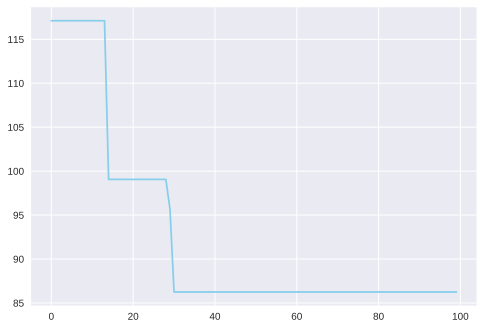

[4, 1, 3, 2, 0]


In [19]:
best, history = genetic_algorithm(
    cities,
    adjacency_mat,
    n_iter=100,
    verbose=False,
    print_interval=20,
    return_history=True,
)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)


# Que muestre el camino

Así que vamos a escribir algunas funciones para generar las coordenadas de la ciudad y las correspondientes matrices de adyacencia.

In [20]:
def generate_cities(n_cities, factor=10):
    return np.random.rand(n_cities, 2) * n_cities * factor

In [21]:
def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)


Generemos una **ciudad** mas grande y mas generaciones

In [22]:
cities = range(100)
city_coordinates = generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=20, n_iter=1000, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)


Output hidden; open in https://colab.research.google.com to view.

Ahora si que muestre el mejor camino

In [23]:
def print_path(best, city_coordinates):
    points = city_coordinates[best]
    x, y = zip(*points)
    plt.plot(x, y, color="skyblue", marker="o")


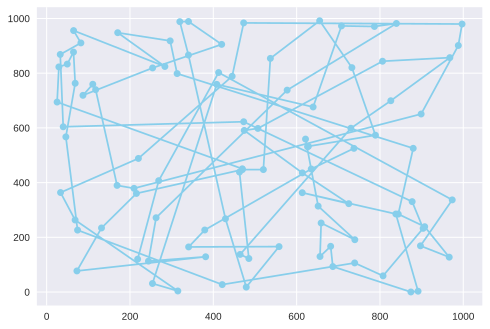

In [24]:
print_path(best, city_coordinates)


Es realmente difícil saber si esta es realmente la ruta óptima, especialmente porque las coordenadas de la ciudad se generaron al azar.

Las metricas es lo unico que nos ayuda

# Tarea

Haga una copia de este algoritmo en su directorio de trabajo y:

1) Implemente un operador de permutacion y vea como se comporta el algoritmo

2) Cambie la funcion de costo con 2 costos como lo viste en las laminas de la clase (un costo para minimizar recorrido y otro para penalizar incorrectos resultados), e indique que pasa en los resultados

# Tarea 1

In [25]:
from itertools import permutations
def permutate(parents):
  return list(permutations(parents))
print(permutate(pop.parents))

[(array([0, 2, 3, 1, 4]), array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 1, 2, 3, 4])), (array([0, 2, 3, 1, 4]), array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4]), array([3, 1, 2, 0, 4])), (array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4])), (array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 1, 2, 3, 4]), array([0, 2, 3, 1, 4])), (array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4]), array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4])), (array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4]), array([3, 1, 2, 0, 4]), array([0, 2, 3, 1, 4])), (array([0, 2, 3, 1, 4]), array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 1, 2, 3, 4])), (array([0, 2, 3, 1, 4]), array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4]), array([3, 1, 2, 0, 4])), (array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 2, 3, 1, 4]), array([0, 1, 2, 3, 4])), (array([0, 2, 3, 1, 4]), array([3, 1, 2, 0, 4]), array([0, 1, 2, 3, 4]), array([0, 2, 3, 1, 4])), (array([0, 2, 3, 1,

# Tarea 2


para ejecutar el cambio en la funcion nesesitas correr la funcion nueva de fitnes,la de abajo. y volver a ejecutar de nuevo la funcion evalute()

In [26]:
def fitness(chromosome,adjacency_mat):

    return sum(
        [
            adjacency_mat[chromosome[i], chromosome[i + 1]]
            for i in range(len(chromosome) - 1)
        ]
    )+10 if len(cities)<len(chromosome) else 0

Population.fitness = fitness
#fitness(chromosome,adjacency_mat)